In [1]:
import scanpy as sc
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import median_abs_deviation as mad
import numpy as np
import anndata as adt

In [2]:
import warnings 
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

In [7]:
adatas_red = []
data_dir = 'C:/Users/MDV/Documents/Pipeline folder Yohan/scP/Output/missforest_completed'

for filename in os.listdir(data_dir):
    if filename.endswith('.h5ad'):
            adata = sc.read_h5ad(os.path.join(data_dir, filename))
            adata.var_names_make_unique()
            adatas_red.append(adata)

print(f"Nombre de fichiers h5ad chargés avec succès : {len(adatas_red)}")

Nombre de fichiers h5ad chargés avec succès : 6


In [8]:
adata = adt.concat(adatas_red, join="outer", index_unique="-", merge="unique")

In [9]:
adata

AnnData object with n_obs × n_vars = 803 × 3776
    obs: 'Id'

In [10]:
adata.X = np.nan_to_num(adata.X, nan=0.0)

In [11]:
os.makedirs('C:/Users/MDV/Documents/Pipeline folder Yohan/scP/Output/concat',exist_ok = True)

In [12]:
file_path = os.path.join('C:/Users/MDV/Documents/Pipeline folder Yohan/scP/Output/concat', 'adata_concat_normalized.h5ad')
adata.write_h5ad(file_path)
print(f"Saved: {file_path}")

Saved: C:/Users/MDV/Documents/Pipeline folder Yohan/scP/Output/concat\adata_concat_normalized.h5ad


In [13]:
adata = sc.read_h5ad('C:/Users/MDV/Documents/Pipeline folder Yohan/scP/Output/concat/adata_concat_normalized.h5ad')

In [14]:
adata

AnnData object with n_obs × n_vars = 803 × 3776
    obs: 'Id'

In [15]:
adata.X = np.nan_to_num(adata.X, nan=0.0)

3776


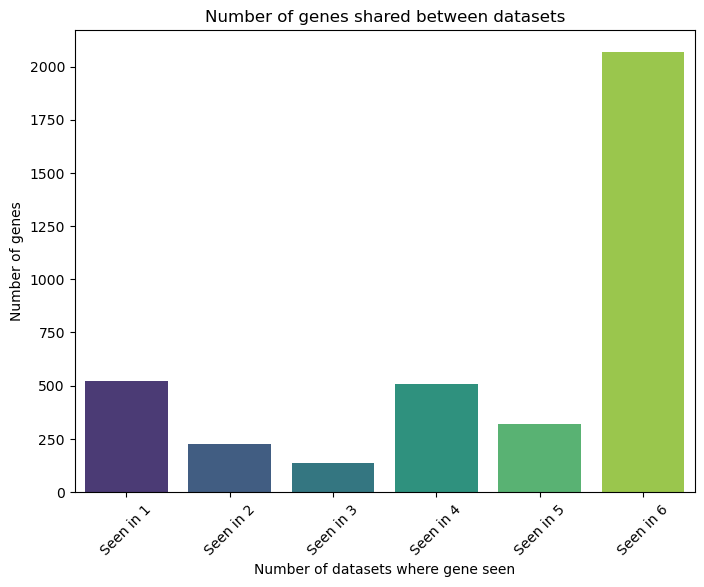

In [16]:
all_genes = list(set().union(*[set(ad.var_names) for ad in adatas_red]))
print(len(all_genes))



presence_matrix = pd.DataFrame(0, index=all_genes, columns=[f"Dataset {ad.obs['Id'][0]}" for ad in adatas_red])

for ad in adatas_red:
    presence_matrix.loc[ad.var_names, f"Dataset {ad.obs['Id'][0]}"] = 1  

compte = pd.DataFrame(0, index=all_genes, columns=[f"Seen in {i+1}" for i in range(len(adatas_red))])
sum_presencematrix = presence_matrix.sum(1)

commun_gene = []
for gene in all_genes:
    presence_count = sum_presencematrix[gene] 
    if presence_count>5:
        commun_gene.append(gene)
    compte.loc[gene, f"Seen in {presence_count}"] = 1  

adata.var['Common']=adata.var_names.isin(commun_gene)

column_sums = compte.sum(axis=0)


plt.figure(figsize=(8, 6))
sns.barplot(x=column_sums.index, y=column_sums.values, palette="viridis")

plt.xlabel("Number of datasets where gene seen")
plt.ylabel("Number of genes")
plt.title("Number of genes shared between datasets")


plt.xticks(rotation=45)

plt.show()

In [17]:
adata.var

,Common
1433B_HUMAN,True
1433E_HUMAN,True
1433F_HUMAN,True
1433G_HUMAN,True
1433S_HUMAN,True
...,...
ZO2_HUMAN,True
ZO3_HUMAN,False
ZRAB2_HUMAN,True
ZSWM8_HUMAN,False


  File "C:\Users\MDV\anaconda3\envs\test1\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\MDV\anaconda3\envs\test1\lib\subprocess.py", line 505, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\MDV\anaconda3\envs\test1\lib\subprocess.py", line 951, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\MDV\anaconda3\envs\test1\lib\subprocess.py", line 1436, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


GFP.NEG3dpi_pg


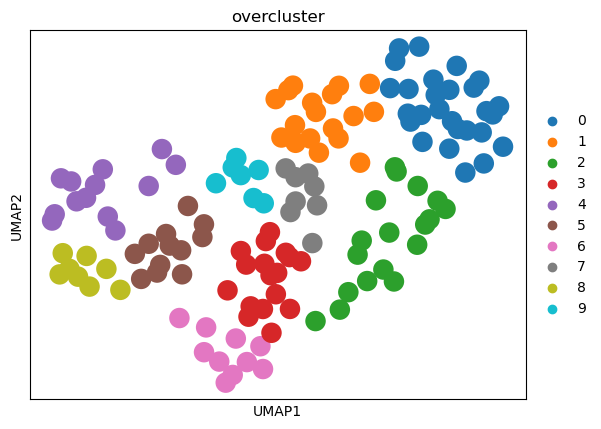

GFP.NEG6dpi_pg


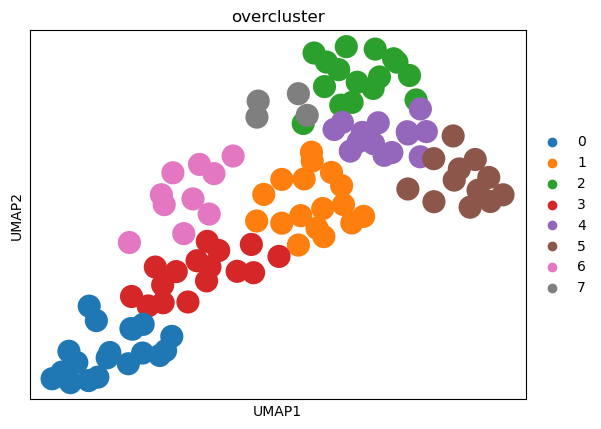

GFP.POS3dpi_pg


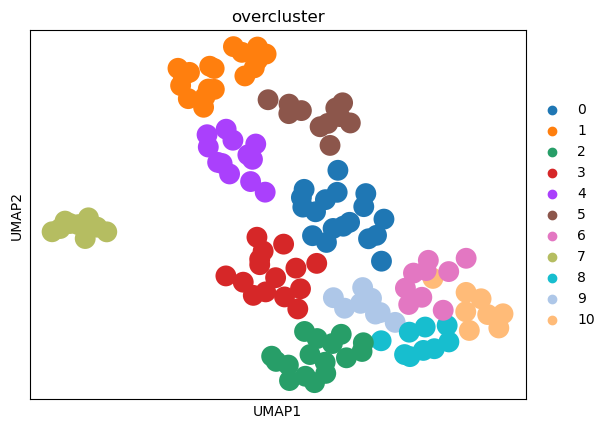

GFP.POS6dpi_pg


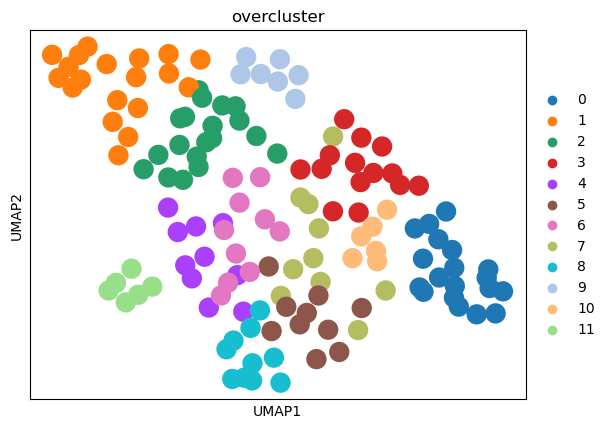

Mock3dpi_pg


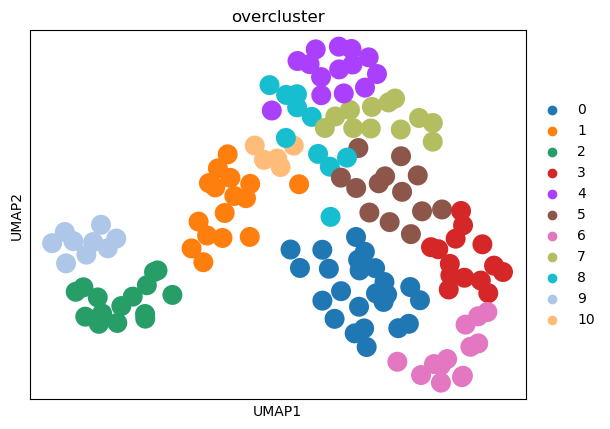

Mock6dpi_pg


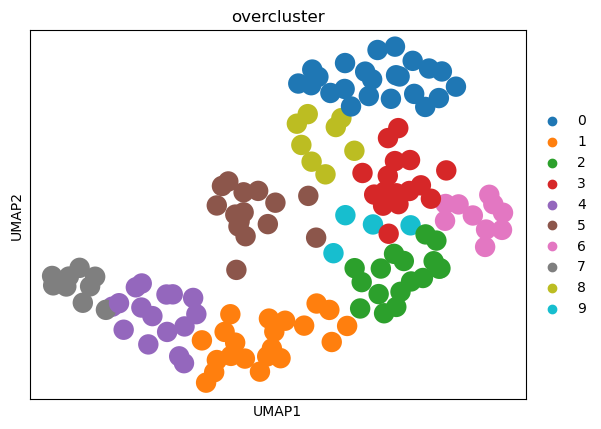

In [18]:
for ad in adatas_red:
    scales_counts = sc.pp.normalize_total(ad, target_sum=None, inplace=False)
    # log1p transform
    ad.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)
    ad.layers["raw_counts"] = ad.X.copy()
    sc.pp.pca(ad)
    sc.pp.neighbors(ad, use_rep = 'X_pca')
    sc.tl.leiden(ad, resolution = 2, key_added = 'overcluster')
    sc.tl.umap(ad)
    print(ad.obs['Id'][0])
    sc.pl.umap(
    ad,
    color=['overcluster'])

GFP.NEG3dpi_pg


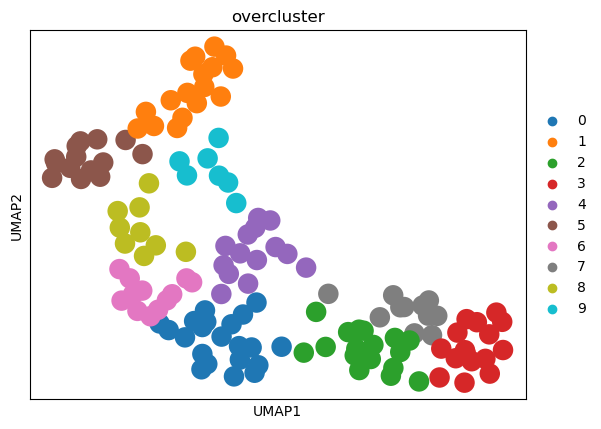

GFP.NEG6dpi_pg


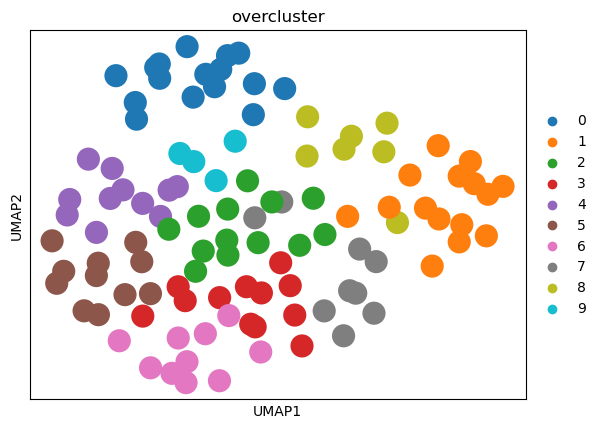

GFP.POS3dpi_pg


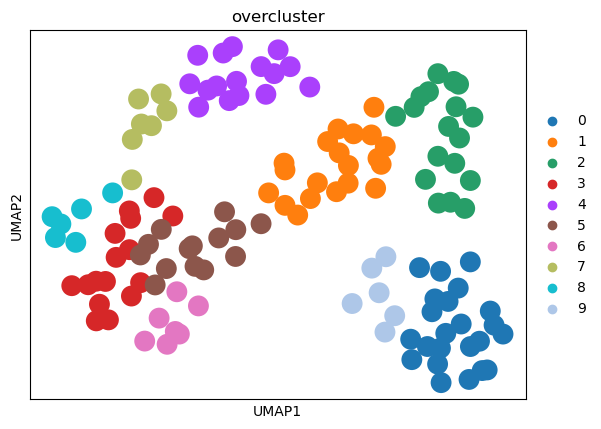

GFP.POS6dpi_pg


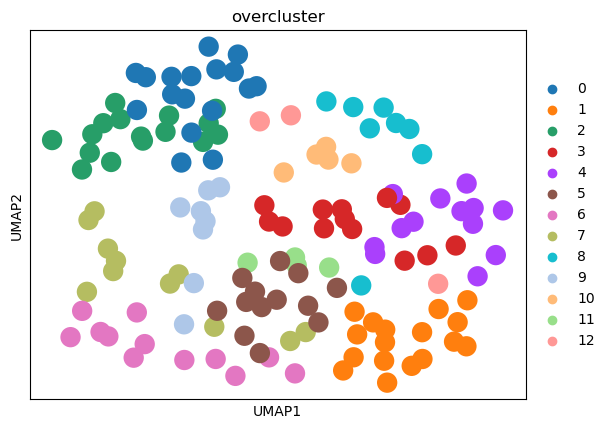

Mock3dpi_pg


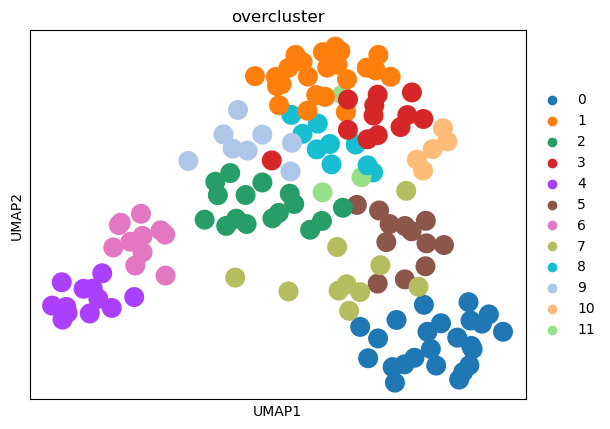

Mock6dpi_pg


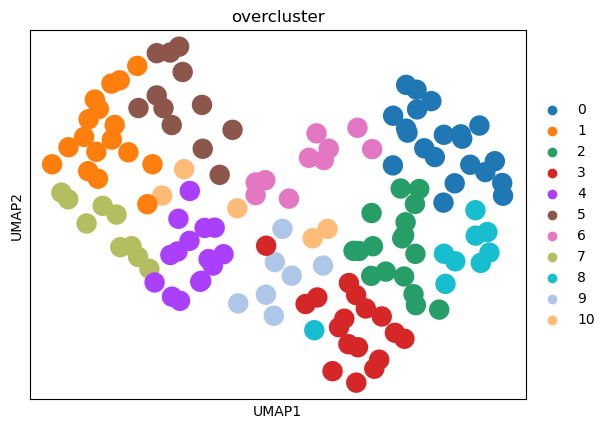

In [19]:
for ade in adatas_red:
    ad = ade.copy()
    ad.X = np.nan_to_num(ad.X, nan=0.0)  
    analytic_pearson = sc.experimental.pp.normalize_pearson_residuals(ad, inplace=False)
    
    X_fixed = analytic_pearson["X"]
    X_fixed[np.isnan(X_fixed)] = 0  
    ad.X = X_fixed
    sc.pp.pca(ad)
    sc.pp.neighbors(ad, use_rep = 'X_pca')
    sc.tl.leiden(ad, resolution = 2, key_added = 'overcluster')
    sc.tl.umap(ad)
    print(ad.obs['Id'][0])
    sc.pl.umap(
    ad,
    color=['overcluster'])

In [20]:
adata_common = adata[:, adata.var['Common']]

In [21]:
adata_common

View of AnnData object with n_obs × n_vars = 803 × 2068
    obs: 'Id'
    var: 'Common'

In [22]:
adata_common.X = np.nan_to_num(adata_common.X, nan=0.0)

In [23]:
adata_common.layers["raw_counts"] = adata_common.X.copy()

In [24]:
scales_counts = sc.pp.normalize_total(adata_common, target_sum=None, inplace=False)
# log1p transform
adata_common.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

In [25]:
adata_common.X = adata_common.layers['log1p_norm']

In [26]:
sc.pp.pca(adata_common)

ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
adata_common

In [27]:
sc.pp.neighbors(adata_common, use_rep = 'X_pca')

ValueError: Did not find X_pca in `.obsm.keys()`. You need to compute it first.

In [33]:
sc.tl.leiden(adata_common, resolution = 2, key_added = 'overcluster')

In [34]:
sc.tl.umap(adata_common)

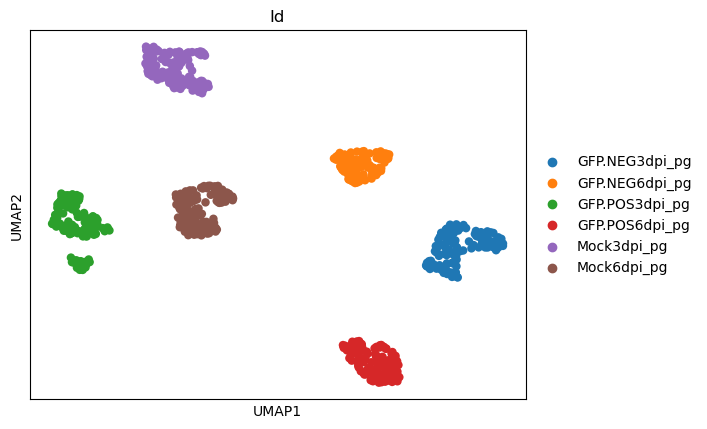

In [35]:
sc.pl.umap(
    adata_common,
    color=['Id']
)

In [36]:
file_path = os.path.join('C:/Users/MDV/Documents/Pipeline folder Yohan/scP/Output/concat', 'adata_concat_normalized.h5ad')
adata_common.write_h5ad(file_path)
print(f"Saved: {file_path}")

Saved: C:/Users/MDV/Documents/Pipeline folder Yohan/scP/Output/concat\adata_concat_normalized.h5ad


In [28]:
from scipy.sparse import csr_matrix

0
0
0
0
0
0


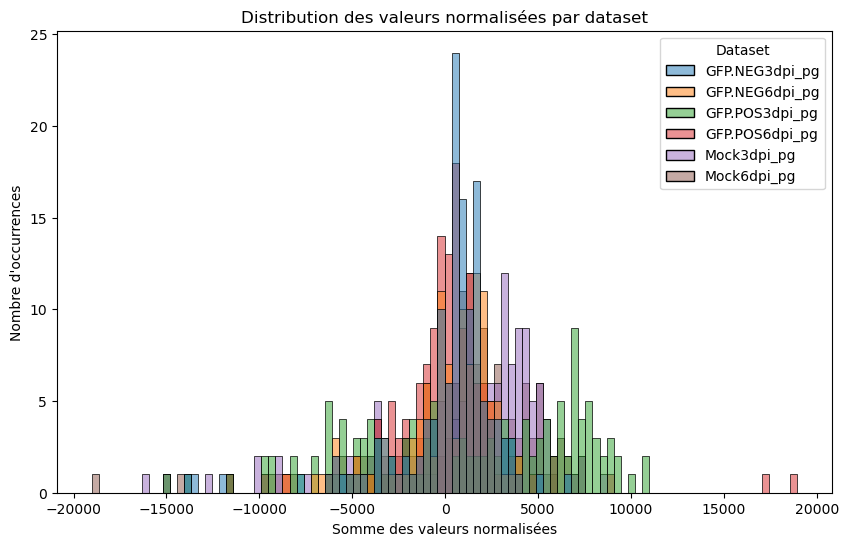

In [29]:
plot_data = []

for ade in adatas_red:
    ad = ade.copy()
    #ad.X = np.nan_to_num(ad.X, nan=0.0)  
    analytic_pearson = sc.experimental.pp.normalize_pearson_residuals(ad, inplace=False)
    
    X_fixed = analytic_pearson["X"]
    nan_after = np.isnan(X_fixed).sum()
    print(nan_after)
    
    plot_data.extend([(x, ad.obs['Id'][0]) for x in csr_matrix(X_fixed).sum(1).A1])

df_plot = pd.DataFrame(plot_data, columns=["Somme Normalisée", "Dataset"])

plt.figure(figsize=(10, 6))
ax = sns.histplot(data=df_plot, x="Somme Normalisée", hue="Dataset", bins=100, kde=False, palette="tab10")

plt.xlabel("Somme des valeurs normalisées")
plt.ylabel("Nombre d'occurrences")
plt.title("Distribution des valeurs normalisées par dataset")

# Afficher le plot
plt.show()

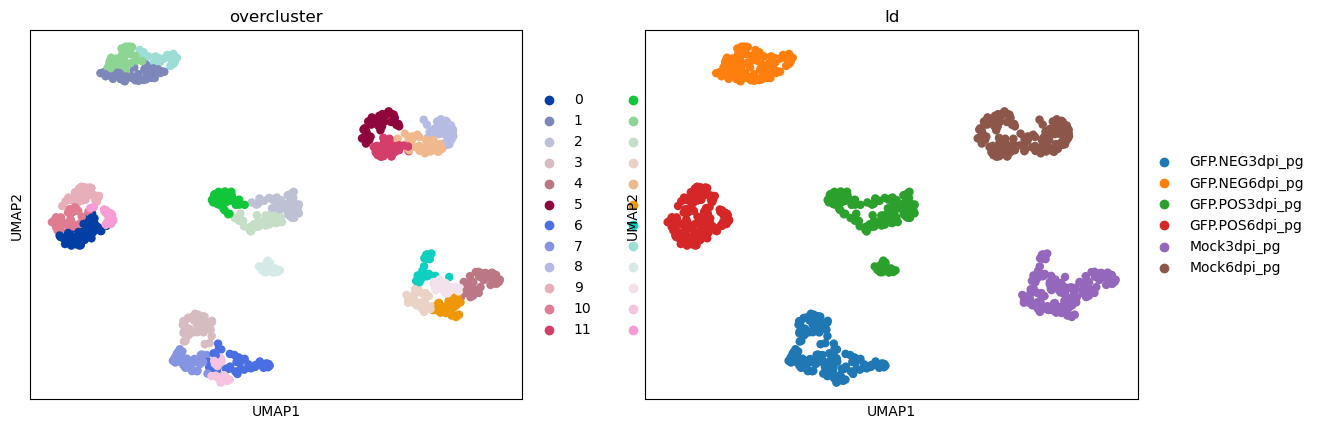

In [30]:
adata_common = adata[:, adata.var['Common']]
adata_common.layers["raw_counts"] = adata_common.X.copy()
analytic_pearson = sc.experimental.pp.normalize_pearson_residuals(adata_common, inplace=False)
X_fixed = analytic_pearson["X"]
X_fixed[np.isnan(X_fixed)] = 0 
adata_common.layers["analytic_pearson_residuals_train"] = csr_matrix(X_fixed)
adata_common.X = adata_common.layers["analytic_pearson_residuals_train"]
sc.pp.pca(adata_common)
sc.pp.neighbors(adata_common, use_rep = 'X_pca')
sc.tl.leiden(adata_common, resolution = 3, key_added = 'overcluster')
sc.tl.umap(adata_common)
sc.pl.umap(
    adata_common,
    color=['overcluster','Id']
)

In [40]:
adata_common

AnnData object with n_obs × n_vars = 803 × 2068
    obs: 'Id', 'overcluster', '_scvi_batch', '_scvi_labels'
    var: 'Common'
    uns: 'pca', 'neighbors', 'overcluster', 'umap', 'overcluster_colors', 'Id_colors', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_pca', 'X_umap', '_scvi_extra_categorical_covs'
    varm: 'PCs'
    layers: 'raw_counts', 'analytic_pearson_residuals_train'
    obsp: 'distances', 'connectivities'

In [32]:
#pip install --upgrade torch lightning


In [33]:
#pip install --upgrade torchaudio torchvision


In [3]:
from scvi.autotune import ModelTuner
import tempfile

import ray
import scanpy as sc
import scvi
import seaborn as sns
import torch
from ray import tune
from scvi import autotune
import os
from matplotlib import pyplot as plt

In [41]:
adata_common.X = adata_common.layers['raw_counts']

In [47]:
adata_common.X

array([[ 16043.    ,  39306.4   ,  15072.2   , ...,   1593.    ,
        232481.    ,  12312.3   ],
       [ 16563.4   ,  42631.6   ,  15211.2   , ...,   1919.82  ,
        222070.    ,  11835.5   ],
       [ 16829.6   ,  40763.9   ,  15376.6   , ...,   2535.29  ,
        221522.    ,  12740.3   ],
       ...,
       [ 13242.4   ,   4714.6   ,   2263.78  , ...,   1424.7169,
         17508.3   ,   5708.65  ],
       [  9820.53  ,   4258.33  ,   2689.6646, ...,   1422.7657,
         15583.4   ,   6153.48  ],
       [ 11470.6   ,   4678.82  ,   2342.21  , ...,   1434.693 ,
         15117.3   ,   5154.76  ]], dtype=float32)

In [49]:
print(np.isnan(adata_common.X).sum(), np.isinf(adata_common.X).sum())

0 0


In [61]:
print(adata_common.X[:10, :10])  

[[16043.   39306.4  15072.2  58753.7  12320.7  52008.9  34450.4  13625.1
  25868.1  13678.4 ]
 [16563.4  42631.6  15211.2  56712.7  11285.4  48035.3  34166.9  14988.4
  26608.3  13103.1 ]
 [16829.6  40763.9  15376.6  57806.1  13538.4  51861.7  32772.4  16310.9
  29387.3  13562.  ]
 [17590.1  52914.6  17149.4  56277.6  12338.   57449.9  34354.7  13246.4
  26887.1  16706.2 ]
 [16247.9  52416.3  13472.5  57228.1  11700.3  57882.1  35012.2  14622.7
  30748.2  15378.8 ]
 [17836.1  45582.8  14725.5  54118.7  12096.7  47941.4  34859.9  15486.9
  31803.8  13203.6 ]
 [17384.1  45690.2  19524.5  55470.7  14954.8  58942.1  29392.1  12512.7
  31882.3  13149.3 ]
 [16951.8  44996.5  16035.3  48105.5  15666.8  51739.4  24630.5  10637.1
  26697.7  15119.8 ]
 [16781.4  39976.7  15438.1  55126.7  13612.4  51874.8  30524.9   9290.94
  23687.5  12532.9 ]
 [16690.2  36935.9  18108.2  59170.1  11501.8  48683.9  36344.3  14913.
  26725.3  14148.4 ]]


In [54]:
sc.pp.filter_genes(adata_common, min_counts=3) 
sc.pp.filter_cells(adata_common, min_counts=10)  

In [55]:
adata_common

AnnData object with n_obs × n_vars = 803 × 2068
    obs: 'Id', 'overcluster', '_scvi_batch', '_scvi_labels', 'n_counts'
    var: 'Common', 'n_counts'
    uns: 'pca', 'neighbors', 'overcluster', 'umap', 'overcluster_colors', 'Id_colors', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_pca', 'X_umap', '_scvi_extra_categorical_covs'
    varm: 'PCs'
    layers: 'raw_counts', 'analytic_pearson_residuals_train'
    obsp: 'distances', 'connectivities'

In [64]:
import torch
print("Torch version:", torch.__version__)
print("CUDA disponible:", torch.cuda.is_available())
print("Nombre de GPU:", torch.cuda.device_count())

if torch.cuda.is_available():
    print("Nom du GPU:", torch.cuda.get_device_name(0))
    print("Version CUDA utilisée par Torch:", torch.version.cuda)
else:
    print("CUDA non détecté")


Torch version: 2.6.0+cu118
CUDA disponible: True
Nombre de GPU: 1
Nom du GPU: NVIDIA RTX 4500 Ada Generation
Version CUDA utilisée par Torch: 11.8


In [6]:
import torch
print(torch.cuda.is_available())  
print(torch.cuda.get_device_name(0)) 

True
NVIDIA RTX 4500 Ada Generation


In [65]:
model_cls = scvi.model.SCVI
model_cls.setup_anndata(adata_common,categorical_covariate_keys = ['Id'])

tuner = ModelTuner(model_cls)

In [66]:
search_space = {
    "n_hidden": tune.choice([92, 128, 192, 256]),
    "n_latent": tune.choice([10, 20, 30, 40, 50, 60]),
    "n_layers": tune.choice([1, 2, 3]),
    "lr": tune.loguniform(1e-4, 1e-2),
    "gene_likelihood": tune.choice(["nb", "zinb"])}

In [70]:
search_space = {
    "n_hidden": tune.choice([128]),
    "n_latent": tune.choice([20]),
    "n_layers": tune.choice([2]),
    "lr": tune.loguniform(1e-4, 1e-3),
    "gene_likelihood": tune.choice(["nb"])
}

In [75]:
results = tuner.fit(adata_common,
                    metric="validation_loss",
                    resources={'gpu': 1},
                    search_space={
                        "n_hidden": tune.choice([92]),
                        "n_latent": tune.choice([20]),
                        "n_layers": tune.choice([2]),
                        "lr": tune.loguniform(1e-4, 1e-3),
                        "gene_likelihood": tune.choice(["nb"])
                    },
                    num_samples=1,
                    max_epochs=10,
                    logging_dir=logging_dir)

C:\Users\MDV\anaconda3\envs\test1\lib\site-packages\ray\tune\impl\tuner_internal.py:125: RayDeprecationWarning: The `RunConfig` class should be imported from `ray.tune` when passing it to the Tuner. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
  _log_deprecation_warning(
2025-03-19 11:53:23,474	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
2025-03-19 11:53:38,986	ERROR tune_controller.py:1331 -- Trial task failed for trial _trainable_907638a3
Traceback (most recent call last):
  File "C:\Users\MDV\anaconda3\envs\test1\lib\site-packages\ray\air\execution\_internal\event_manager.py", line 110, in resolve_future
    result = ray.

KeyError: 'validation_loss'

In [74]:
print(results.metrics)

NameError: name 'results' is not defined

In [67]:
logging_dir = os.path.abspath("C:/ray_logs")

In [68]:
def short_dirname_creator(trial):
    return f"trial_{trial.trial_id}"

In [71]:
results = tuner.fit(adata_common, metric="validation_loss",
                    resources = {'gpu': 1}, 
                    search_space = search_space,
                   num_samples = 5,
                   max_epochs = 20,
                    logging_dir = logging_dir 
                   )

C:\Users\MDV\anaconda3\envs\test1\lib\site-packages\ray\tune\impl\tuner_internal.py:125: RayDeprecationWarning: The `RunConfig` class should be imported from `ray.tune` when passing it to the Tuner. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
  _log_deprecation_warning(
2025-03-19 11:42:01,798	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
2025-03-19 11:42:15,270	ERROR tune_controller.py:1331 -- Trial task failed for trial _trainable_e9ee87b1
Traceback (most recent call last):
  File "C:\Users\MDV\anaconda3\envs\test1\lib\site-packages\ray\air\execution\_internal\event_manager.py", line 110, in resolve_future
    result = ray.

RuntimeError: No best trial found for the given metric: validation_loss. This means that no trial has reported this metric, or all values reported for this metric are NaN. To not ignore NaN values, you can set the `filter_nan_and_inf` arg to False.

In [ ]:
best_vl = 10000
best_i = 0
for i, res in enumerate(results.results):
    vl = res.metrics['validation_loss']

    if vl < best_vl:
        best_vl = vl
        best_i = i

In [ ]:
results.results[best_i]

In [20]:
model = scvi.model.SCVI(adata)

In [21]:
kwargs = {'lr': 0.0026}

In [12]:
model.train(max_epochs = 200, early_stopping = True, plan_kwargs = kwargs)

NameError: name 'model' is not defined